In [1]:
# Autoreload possibly interferes with IntelliJ debugging
# %reload_ext autoreload
# %autoreload 2
import logging
from datetime import datetime
# class FlushHandler(logging.StreamHandler):
#     def emit(self, record):e
#         super().emit(record)
#         self.flush()
import io
import sys
import contextlib
import traceback
from tqdm.auto import tqdm

from importlib import reload

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
# log = lambda msg: logging.info(msg)
log = lambda msg: print(f"{datetime.today()} {msg}")

#assert False
global_force = False

import pandas as pd
import os

input_dir = "C:\\dev\\play\\brainwave-data"
stats_df = pd.read_csv(input_dir + os.path.sep + "stats.csv")

# Find Brainflow files that haven't been copied over

In [2]:
import pytz
from tqdm import tqdm
import paramiko
import re
from datetime import datetime, timedelta
import os
import dotenv
dotenv.load_dotenv()

# Define the time window
time_window = timedelta(minutes=10)

# Define the remote server details
hostname = os.getenv('SSH_HOST')
username = os.getenv('SSH_USERNAME')
password = os.getenv('SSH_PASSWORD')
remote_dir = '/home/graham/dev/Brainwave-Data'
local_dir = input_dir

# Create an SSH client
ssh = paramiko.SSHClient()
ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())
ssh.connect(hostname, username=username, password=password, compress=True)

# List files in the remote directory
stdin, stdout, stderr = ssh.exec_command(f'find {remote_dir} -name "*.brainflow.csv" -size +200M -printf "%f\\n"')
remote_brainflow_files = stdout.read().decode().splitlines()


2025-05-10 09:08:41,925 - INFO - Connected (version 2.0, client OpenSSH_9.6)
2025-05-10 09:08:42,356 - INFO - Authentication (password) successful!


In [3]:
remote_brainflow_files

['2024-09-30-21-27-49.brainflow.csv',
 '2024-10-01-21-36-11.brainflow.csv',
 '2024-10-02-21-21-15.brainflow.csv',
 '2024-10-04-21-13-39.brainflow.csv',
 '2024-10-05-21-09-47.brainflow.csv',
 '2024-10-06-21-29-18.brainflow.csv',
 '2024-10-07-21-35-18.brainflow.csv',
 '2024-10-08-21-21-34.brainflow.csv',
 '2024-10-09-21-22-04.brainflow.csv',
 '2024-10-11-21-16-27.brainflow.csv',
 '2024-10-15-22-01-52.brainflow.csv',
 '2024-10-21-21-30-19.brainflow.csv',
 '2024-10-23-21-24-03.brainflow.csv',
 '2024-10-24-21-35-33.brainflow.csv',
 '2024-10-29-20-42-12.brainflow.csv',
 '2024-10-30-21-26-55.brainflow.csv',
 '2024-11-01-21-32-22.brainflow.csv',
 '2024-11-02-21-29-03.brainflow.csv',
 '2024-11-04-21-20-51.brainflow.csv',
 '2024-11-05-21-34-15.brainflow.csv',
 '2024-11-07-21-26-18.brainflow.csv',
 '2024-11-08-21-16-53.brainflow.csv',
 '2024-11-09-21-27-51.brainflow.csv',
 '2024-11-12-21-11-43.brainflow.csv',
 '2024-11-16-21-54-46.brainflow.csv',
 '2024-11-19-21-29-04.brainflow.csv',
 '2024-11-20

In [4]:
files_to_copy = remote_brainflow_files.copy()


for root, dirs, files in os.walk(input_dir):
    #for idx, file_name in enumerate(tqdm(dirs, desc="Converting Brainflow to FIF")):
    for idx, file_name in enumerate(files):
        full_input_filename = os.path.join(root, file_name)
        if ".brainflow.csv.bz2" in full_input_filename:
            #print(f"Processing {full_input_filename}")
            file_name_without_bz2 = file_name.removesuffix(".bz2")
            already_have = file_name_without_bz2 in remote_brainflow_files
            print(f"Already have {full_input_filename}: {already_have}")
            if already_have:
                files_to_copy.remove(file_name_without_bz2)



Already have C:\dev\play\brainwave-data\08-07-2024--22-51-16\08-07-2024--22-51-16.brainflow.csv.bz2: False
Already have C:\dev\play\brainwave-data\09-07-2024--22-52-25\09-07-2024--22-52-25.brainflow.csv.bz2: False
Already have C:\dev\play\brainwave-data\2024-07-15-09-10-07\2024-07-15-09-10-07.brainflow.csv.bz2: False
Already have C:\dev\play\brainwave-data\2024-07-16-23-14-52\2024-07-16-23-14-52.brainflow.csv.bz2: False
Already have C:\dev\play\brainwave-data\2024-07-24-18-57-03\2024-07-24-18-57-03.brainflow.csv.bz2: False
Already have C:\dev\play\brainwave-data\2024-09-03-21-10-58\2024-09-03-21-10-58.brainflow.csv.bz2: False
Already have C:\dev\play\brainwave-data\2024-09-04-21-44-08\2024-09-04-21-44-08.brainflow.csv.bz2: False
Already have C:\dev\play\brainwave-data\2024-09-08-21-01-39\2024-09-08-21-01-39.brainflow.csv.bz2: False
Already have C:\dev\play\brainwave-data\2024-09-10-21-22-21\2024-09-10-21-22-21.brainflow.csv.bz2: False
Already have C:\dev\play\brainwave-data\2024-09-11-

In [5]:
files_to_copy

['2025-05-09-20-57-43.brainflow.csv']

In [6]:
import os
import bz2
from tqdm import tqdm

sftp = ssh.open_sftp()
for file in files_to_copy:
    remote_file_path = remote_dir + "/" + file
    local_file_path = os.path.join(input_dir, file)
    log(f"Copying Brainflow backup remote:{remote_file_path} to {local_file_path}")

    # Get the file size
    remote_file_size = sftp.stat(remote_file_path).st_size

    with tqdm(total=remote_file_size, unit='B', unit_scale=True, desc=file, ascii=True) as pbar:
        local_file_path = os.path.join(input_dir, file)
    
        def callback(transferred_so_far, total_to_transfer):
            pbar.update(transferred_so_far - pbar.n)
    
        # Create a file-like object that writes to the local file
        with open(local_file_path, 'wb') as local_file:
            sftp.getfo(remote_file_path, local_file, callback=callback)
sftp.close()
ssh.close()


2025-05-10 09:08:44,276 - INFO - [chan 1] Opened sftp connection (server version 3)


2025-05-10 09:08:44.277881 Copying Brainflow backup remote:/home/graham/dev/Brainwave-Data/2025-05-09-20-57-43.brainflow.csv to C:\dev\play\brainwave-data\2025-05-09-20-57-43.brainflow.csv


2025-05-09-20-57-43.brainflow.csv: 100%|##########| 2.51G/2.51G [00:40<00:00, 62.8MB/s] 
2025-05-10 09:09:24,410 - INFO - [chan 1] sftp session closed.


## Convert Brainflow files to FIF

In [7]:
def get_brainflow_compressed_filename(full_input_filename: str) -> str:
    full_output_dirname = webserver.output_dirname(full_input_filename)
    compressed_full_output_filename = str(os.path.join(full_output_dirname, os.path.basename(full_input_filename))) + '.bz2'
    return compressed_full_output_filename

In [8]:
from datetime import datetime

import webserver
import convert
# import zstandard as zstd
import os
import bz2
import time
import shutil

errors = []
processed = []

from sample_rates import real_sample_rate

# Could get these working later
skip_list = ['2024-09-10-21-22-21']

def compress_bz2(input_file, output_file):
    start_time = time.time()
    with open(input_file, 'rb') as f_in:
        with bz2.open(output_file, 'wb', compresslevel=9) as f_out:
            shutil.copyfileobj(f_in, f_out)
    end_time = time.time()
    return end_time - start_time, os.path.getsize(output_file)

for root, dirs, files in os.walk(input_dir):
    #for idx, file_name in enumerate(tqdm(dirs, desc="Converting Brainflow to FIF")):
    for idx, file_name in enumerate(files):
        full_input_filename = os.path.join(root, file_name)
        try:
            if full_input_filename.endswith(".brainflow.csv"):
                full_output_dirname = webserver.output_dirname(full_input_filename)
                full_output_filename = str(os.path.join(full_output_dirname, 'raw.fif'))
                
                compressed_full_output_filename = get_brainflow_compressed_filename(full_input_filename)
                
                if not os.path.exists(compressed_full_output_filename):
                    log(f"Compressing file {full_input_filename} to " + compressed_full_output_filename)
                    processed.append("Compressing " + full_input_filename)
                    try:
                        os.mkdir(os.path.dirname(compressed_full_output_filename))
                    except:
                        pass
                    compress_bz2(full_input_filename, compressed_full_output_filename) 
                    
                if os.path.exists(full_output_filename):
                    log(f"Skipping file {full_input_filename} as {full_output_filename} and {compressed_full_output_filename} already exist")
                    continue
                should_skip = False
                for s in skip_list:
                    if s in full_input_filename:
                        log(f"Skipping file {full_input_filename}")
                        should_skip = True
                if not should_skip:
                    log(f"Processing file {full_input_filename}")
                    processed.append("Processing " + full_input_filename)
                    channels = None
                    date_time_str = os.path.basename(full_input_filename).removesuffix(".brainflow.csv")
                    date_time_obj = datetime.strptime(date_time_str, '%Y-%m-%d-%H-%M-%S')
                    log(f"Date time obj: {date_time_obj} {date_time_obj > datetime(2025, 3, 12, 0, 0, 0)} {date_time_str}")
                    if (date_time_obj > datetime(2025, 3, 12, 0, 0, 0) and date_time_obj < datetime(2025, 3, 14, 0, 0, 0)):
                        channels = ['Fpz-M1', 'O2-M1']
                    elif (date_time_obj > datetime(2024, 9, 1, 0, 0, 0)):
                        channels = ['Fpz-M1']
        
                    if channels is not None:
                        log(f"Processing file {full_input_filename} with channels {channels}")
                        # Changing to gap-filling on 30th Nov '24
                        # Fixing sample rate on 21st Mar '25
                        convert.convert_and_save_brainflow_file_with_gap_filling(log, full_input_filename, full_output_filename, channels, real_sample_rate)

        except Exception as e:
            msg = "Error processing file: " + full_input_filename
            log(msg)
            log(e)
            errors.append(msg)


2025-05-10 09:09:56.211008 Skipping file C:\dev\play\brainwave-data\2024-12-28-21-33-53.brainflow.csv as C:\dev\play\brainwave-data\2024-12-28-21-33-53\raw.fif and C:\dev\play\brainwave-data\2024-12-28-21-33-53\2024-12-28-21-33-53.brainflow.csv.bz2 already exist
2025-05-10 09:09:56.211824 Skipping file C:\dev\play\brainwave-data\2024-12-29-21-15-24.brainflow.csv as C:\dev\play\brainwave-data\2024-12-29-21-15-24\raw.fif and C:\dev\play\brainwave-data\2024-12-29-21-15-24\2024-12-29-21-15-24.brainflow.csv.bz2 already exist
2025-05-10 09:09:56.212240 Skipping file C:\dev\play\brainwave-data\2024-12-30-21-34-52.brainflow.csv as C:\dev\play\brainwave-data\2024-12-30-21-34-52\raw.fif and C:\dev\play\brainwave-data\2024-12-30-21-34-52\2024-12-30-21-34-52.brainflow.csv.bz2 already exist
2025-05-10 09:09:56.212712 Skipping file C:\dev\play\brainwave-data\2024-12-31-21-12-28.brainflow.csv as C:\dev\play\brainwave-data\2024-12-31-21-12-28\raw.fif and C:\dev\play\brainwave-data\2024-12-31-21-12-28\

c:\dev\Brainwave-Processor\convert.py:183: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idx_and_eeg_channels_and_timestamp['datetime'] = pd.to_datetime(idx_and_eeg_channels_and_timestamp['timestamp'],unit="s").dt.tz_localize('UTC')
Processing rows: 100%|██████████| 10487247/10487247 [00:05<00:00, 1897260.41it/s]


Gaps:  datetime
False    10482554
True           20
Name: count, dtype: int64


Processing rows:   5%|▌         | 539166/10482573 [00:03<00:53, 187514.98it/s]

Gap 548670 start time:  2025-05-09 20:34:15.265657902+00:00
Gap 548670 end time:  2025-05-09 20:34:52.964165926+00:00
Gap 548749 start time:  2025-05-09 20:34:53.596565008+00:00
Gap 548749 end time:  2025-05-09 20:34:54.227250099+00:00
Gap 548836 start time:  2025-05-09 20:34:54.744246006+00:00
Gap 548836 end time:  2025-05-09 20:34:55.641927004+00:00
Gap 548888 start time:  2025-05-09 20:34:56.039015055+00:00
Gap 548888 end time:  2025-05-09 20:34:57.938391924+00:00
Gap 548902 start time:  2025-05-09 20:34:58.121531010+00:00
Gap 548902 end time:  2025-05-09 20:35:20.524825096+00:00
Gap 548904 start time:  2025-05-09 20:35:20.524840117+00:00
Gap 548904 end time:  2025-05-09 20:35:23.594130039+00:00
Gap 548917 start time:  2025-05-09 20:35:23.712272882+00:00
Gap 548917 end time:  2025-05-09 20:35:26.649894953+00:00
Gap 548924 start time:  2025-05-09 20:35:26.699758053+00:00
Gap 548924 end time:  2025-05-09 20:35:27.618383884+00:00
Gap 554426 start time:  2025-05-09 20:35:49.779694080+00

Processing rows:  10%|▉         | 998869/10482573 [00:05<00:52, 180692.90it/s]

Gap 968317 start time:  2025-05-09 21:03:24.701011896+00:00
Gap 968317 end time:  2025-05-09 21:03:25.720868111+00:00


Processing rows:  20%|█▉        | 2067933/10482573 [00:11<00:49, 171723.58it/s]

Gap 2043426 start time:  2025-05-09 22:14:59.616776943+00:00
Gap 2043426 end time:  2025-05-09 22:15:00.696746111+00:00


Processing rows:  29%|██▊       | 2999535/10482573 [00:15<00:35, 212008.72it/s]

Gap 2969065 start time:  2025-05-09 23:16:37.690759897+00:00
Gap 2969065 end time:  2025-05-09 23:16:38.710771084+00:00


Processing rows:  30%|██▉       | 3133026/10482573 [00:16<00:38, 189243.48it/s]

Gap 3118250 start time:  2025-05-09 23:26:34.616749048+00:00
Gap 3118250 end time:  2025-05-09 23:26:35.637409925+00:00


Processing rows:  40%|████      | 4230211/10482573 [00:22<00:29, 209594.94it/s]

Gap 4193299 start time:  2025-05-10 00:38:09.563527107+00:00
Gap 4193299 end time:  2025-05-10 00:38:10.644323111+00:00


Processing rows:  56%|█████▌    | 5864209/10482573 [00:31<00:24, 185258.10it/s]

Gap 5873994 start time:  2025-05-10 02:30:03.518320083+00:00
Gap 5873994 end time:  2025-05-10 02:30:04.359095097+00:00
Gap 5874040 start time:  2025-05-10 02:30:04.702761889+00:00
Gap 5874040 end time:  2025-05-10 02:30:06.751130104+00:00
Gap 5874052 start time:  2025-05-10 02:30:06.766882896+00:00
Gap 5874052 end time:  2025-05-10 02:31:26.419833899+00:00


Processing rows:  61%|██████    | 6352817/10482573 [00:34<00:24, 168501.70it/s]

Gap 6322993 start time:  2025-05-10 03:01:19.505182981+00:00
Gap 6322993 end time:  2025-05-10 03:01:20.526247025+00:00


Processing rows:  71%|███████   | 7427899/10482573 [00:41<00:18, 164560.25it/s]

Gap 7398132 start time:  2025-05-10 04:12:54.499305964+00:00
Gap 7398132 end time:  2025-05-10 04:12:55.520648003+00:00


Processing rows:  91%|█████████▏| 9588676/10482573 [00:54<00:05, 163922.56it/s]

Gap 9548697 start time:  2025-05-10 06:36:04.424894094+00:00
Gap 9548697 end time:  2025-05-10 06:36:05.446557999+00:00


Processing rows: 100%|██████████| 10482573/10482573 [00:59<00:00, 176375.67it/s]
c:\dev\Brainwave-Processor\convert.py:153: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  copied.fillna('', inplace=True)


2025-05-10 09:22:58.836972 Initial timestamp: 2025-05-09 19:57:43.783482075+00:00 from 1746820663.783482
2025-05-10 09:22:58.928579 Info <Info | 7 non-empty values
 bads: []
 ch_names: Fpz-M1
 chs: 1 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 125.2 Hz
 meas_date: 2025-05-09 19:57:43 UTC
 nchan: 1
 projs: []
 sfreq: 250.4 Hz
>
2025-05-10 09:22:59.141789 Memory Usage: 3237.73 MB GC to 3237.73 MB
2025-05-10 09:22:59.144715 Saving to C:\dev\play\brainwave-data\2025-05-09-20-57-43\raw.fif


In [9]:
errors

[]

In [10]:
processed

['Compressing C:\\dev\\play\\brainwave-data\\2025-05-09-20-57-43.brainflow.csv',
 'Processing C:\\dev\\play\\brainwave-data\\2025-05-09-20-57-43.brainflow.csv']

## Run YASA pipeline on FIF files

("2025-05-10 09:23:01.288632 Processing file: C:\\dev\\play\\brainwave-data\\2024-09-19-21-29-42\\raw.fif\n2025-05-10 09:23:01.289545 Loading cached file C:\\dev\\play\\brainwave-data\\2024-09-19-21-29-42\\raw.yasa.csv\n2025-05-10 09:23:01.295018 Forced rebuild\n2025-05-10 09:23:01.295060 Loading MNE file C:\\dev\\play\\brainwave-data\\2024-09-19-21-29-42\\raw.fif\n2025-05-10 09:23:01.295067 Reading file C:\\dev\\play\\brainwave-data\\2024-09-19-21-29-42\\raw.fif\n2025-05-10 09:23:02.155270 Finished reading file C:\\dev\\play\\brainwave-data\\2024-09-19-21-29-42\\raw.fif\n2025-05-10 09:23:03.878643 Start date: 2024-09-19 20:29:51.950311+00:00 channels: ['Fpz-M1'] sfreq: 250.0\n2025-05-10 09:23:04.121311 Memory Usage: 511.01 MB GC to 511.01 MB\n2025-05-10 09:23:04.121362 Saving as EDF\nSaved metadata to C:\\dev\\play\\brainwave-data\\2024-09-19-21-29-42\\raw.json\nSaved recording data to C:\\dev\\play\\brainwave-data\\2024-09-19-21-29-42\\raw.bin\nFile size: 16.87 MB\n2025-05-10 09:23:0

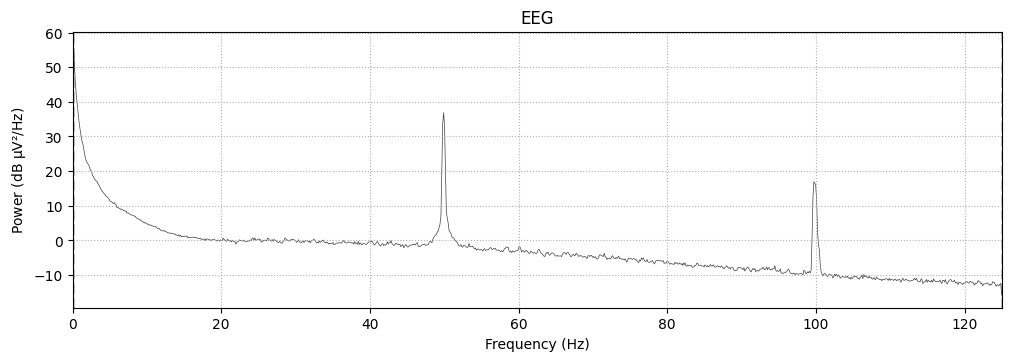

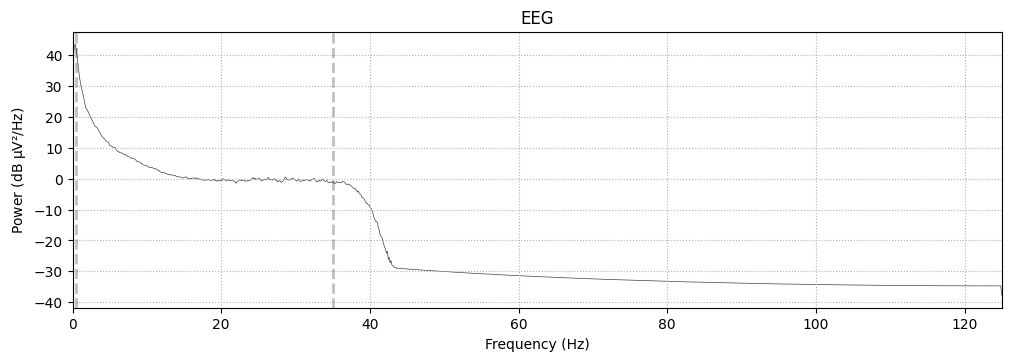

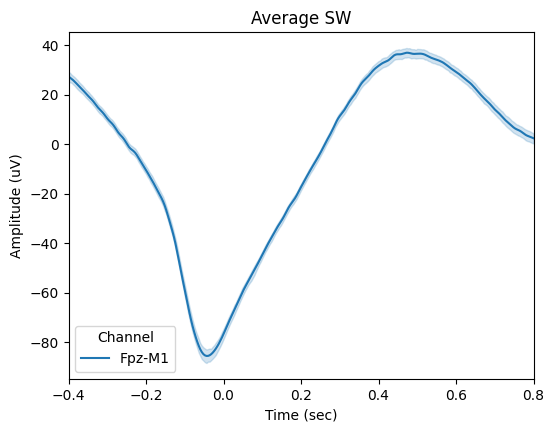

In [11]:
import pandas as pd
import run_feature_pipeline
import os
from concurrent.futures import ThreadPoolExecutor, as_completed

errors = []
dataframes = []

# Could get these working later
skip_list = ['2024-07-23-22-40-25', '2024-07-28-22-29-49', '2024-09-18-21-25-08', '2024-09-18-21-28-11']
import io
import sys
import contextlib
import traceback
from importlib import reload

import convert
reload(convert)

reload(run_feature_pipeline)

import run_yasa
reload(run_yasa)

def process_file(root, dir_name, force=False):
    output_buffer = io.StringIO()
    with contextlib.redirect_stdout(output_buffer), contextlib.redirect_stderr(output_buffer):

        try:
            input_file = os.path.join(root, dir_name, "raw.fif")
            if dir_name in skip_list:
                log(f"Skipping {dir_name}: {input_file}")
                return None, False, output_buffer.getvalue(), "Skipped"

            log(f"Processing file: {input_file}")
            if os.path.exists(input_file):
                yasa_df, cached = run_feature_pipeline.cached_pipeline(log, input_file, force or global_force)
                return yasa_df, cached, output_buffer.getvalue(), True
            else:
                log(f"File not found: {input_file}")
                return None, False, output_buffer.getvalue(), "File not found"

        except Exception as e:
            traceback.print_exc()
            msg = f"Error processing file: {input_file} - {e}"
            log(msg)
            errors.append(msg)
            return None, False, output_buffer.getvalue(), "Error: " + str(e)

# Testing
yasa_df, cached, stdout, success_or_msg = process_file("C:\\dev\\play\\brainwave-data", "2024-09-19-21-29-42", True)
stdout, success_or_msg

In [12]:
results = pd.DataFrame(columns=['dir_name', 'cached', 'stdout', 'success_or_msg'])

from tqdm.auto import tqdm

dirs = next(os.walk(input_dir))[1]
for idx, dir_name in enumerate(tqdm(dirs, desc="YASA pipeline")):
    yasa_df, cached, stdout, success_or_msg = process_file(input_dir, dir_name)
    results.loc[len(results)] = [dir_name, cached, stdout, success_or_msg]

results

YASA pipeline:   0%|          | 0/171 [00:00<?, ?it/s]

,dir_name,cached,stdout,success_or_msg
0,08-07-2024--22-51-16,False,2025-05-10 09:23:35.987699 Processing file: C:...,File not found
1,09-07-2024--22-52-25,False,2025-05-10 09:23:35.989245 Processing file: C:...,File not found
2,2024-07-08-22-51-16,True,2025-05-10 09:23:35.991545 Processing file: C:...,True
3,2024-07-11-22-46-18,True,2025-05-10 09:23:35.998114 Processing file: C:...,True
4,2024-07-12-22-38-58,True,2025-05-10 09:23:36.015058 Processing file: C:...,True
...,...,...,...,...
166,2025-04-21-21-33-06,True,2025-05-10 09:23:37.470431 Processing file: C:...,True
167,2025-04-22-21-27-02,True,2025-05-10 09:23:37.480608 Processing file: C:...,True
168,2025-05-09-20-57-43,False,2025-05-10 09:23:37.489152 Processing file: C:...,True
169,compressed_files,False,2025-05-10 09:24:09.446295 Processing file: C:...,File not found


# Artifacts

In [13]:
import os
import io

from importlib import reload
import notebooks.EEGArtifacts.eeg_artifacts
reload(notebooks.EEGArtifacts.eeg_artifacts)


# Testing
artifacts_df, cached, stdout, success_or_msg = notebooks.EEGArtifacts.eeg_artifacts.process_artifacts("C:\\dev\\play\\brainwave-data", "2025-02-12-20-34-56", False)
stdout, success_or_msg

('Processing file: C:\\dev\\play\\brainwave-data\\2025-02-12-20-34-56\\raw.fif\n',
 True)

In [14]:
from importlib import reload
import notebooks.EEGArtifacts.eeg_artifacts
reload(notebooks.EEGArtifacts.eeg_artifacts)

results = pd.DataFrame(columns=['dir_name', 'cached', 'stdout', 'success_or_msg'])

dirs = next(os.walk(input_dir))[1]
for idx, dir_name in enumerate(tqdm(dirs, desc="Artifacts pipeline")):
# for idx, dir_name in enumerate(dirs):
    # print(dir_name)
    artifacts_df, cached, stdout, success_or_msg = notebooks.EEGArtifacts.eeg_artifacts.process_artifacts(input_dir, dir_name, global_force)
    results.loc[len(results)] = [dir_name, cached, stdout, success_or_msg]

results

Artifacts pipeline:   0%|          | 0/171 [00:00<?, ?it/s]

,dir_name,cached,stdout,success_or_msg
0,08-07-2024--22-51-16,False,Processing file: C:\dev\play\brainwave-data\08...,File not found C:\dev\play\brainwave-data\08-0...
1,09-07-2024--22-52-25,False,Processing file: C:\dev\play\brainwave-data\09...,File not found C:\dev\play\brainwave-data\09-0...
2,2024-07-08-22-51-16,True,Processing file: C:\dev\play\brainwave-data\20...,True
3,2024-07-11-22-46-18,True,Processing file: C:\dev\play\brainwave-data\20...,True
4,2024-07-12-22-38-58,True,Processing file: C:\dev\play\brainwave-data\20...,True
...,...,...,...,...
166,2025-04-21-21-33-06,True,Processing file: C:\dev\play\brainwave-data\20...,True
167,2025-04-22-21-27-02,True,Processing file: C:\dev\play\brainwave-data\20...,True
168,2025-05-09-20-57-43,False,Processing file: C:\dev\play\brainwave-data\20...,True
169,compressed_files,False,Processing file: C:\dev\play\brainwave-data\co...,File not found C:\dev\play\brainwave-data\comp...


# Physiological pipeline

In [15]:
import traceback
import os

from importlib import reload
import run_physical_features_pipeline
reload(run_physical_features_pipeline)
import io
import contextlib
from datetime import datetime, timedelta


def process_file_for_physical(root, dir_name, force=False):
    output_buffer = io.StringIO()
    with contextlib.redirect_stdout(output_buffer), contextlib.redirect_stderr(output_buffer):
        input_fif_file = os.path.join(root, dir_name, "raw.fif")
        input_csv_file = os.path.join(root, dir_name, "raw.yasa.csv")
    #     try:
        if os.path.exists(input_csv_file):
            yasa_df = pd.read_csv(input_csv_file)
            physical_features_df_30s, physical_features_df_1s, cached = run_physical_features_pipeline.cached_physical_features_pipeline(log, input_fif_file, yasa_df, force or global_force)
            return physical_features_df_30s, physical_features_df_1s, cached, output_buffer.getvalue(), True
        else:
            log(f"File not found: {input_fif_file} or {input_csv_file}")
            return None, None, False, output_buffer.getvalue(), "File not found"
        # except Exception as e:
        #     return None, False, output_buffer.getvalue(), (str(e) + " " + traceback.format_exc())

# Testing
# physical_features_df_30s, physical_features_df_1s, cached, stdout, success_or_msg = process_file_for_physical("C:\\dev\\play\\brainwave-data", "2025-03-20-21-22-08", True)
# # display(stdout)
# display(success_or_msg)
# # display(physical_features_df_30s)

In [16]:
from tqdm.auto import tqdm

results = pd.DataFrame(columns=['dir_name', 'cached', 'stdout', 'success_or_msg'])

dirs = next(os.walk(input_dir))[1]
for idx, dir_name in enumerate(tqdm(dirs, desc="Physiological pipeline")):
    _, _, cached, stdout, success_or_msg = process_file_for_physical(input_dir, dir_name)
    results.loc[len(results)] = [dir_name, cached, stdout, success_or_msg]

results

Physiological pipeline:   0%|          | 0/171 [00:00<?, ?it/s]

,dir_name,cached,stdout,success_or_msg
0,08-07-2024--22-51-16,False,2025-05-10 09:24:15.114655 File not found: C:\...,File not found
1,09-07-2024--22-52-25,False,2025-05-10 09:24:15.116239 File not found: C:\...,File not found
2,2024-07-08-22-51-16,True,2025-05-10 09:24:15.121057 Loading cached 30s ...,True
3,2024-07-11-22-46-18,True,2025-05-10 09:24:15.133320 Loading cached 30s ...,True
4,2024-07-12-22-38-58,True,2025-05-10 09:24:15.146756 Loading cached 30s ...,True
...,...,...,...,...
166,2025-04-21-21-33-06,True,2025-05-10 09:24:22.051158 Loading cached 30s ...,True
167,2025-04-22-21-27-02,True,2025-05-10 09:24:22.079300 Loading cached 30s ...,True
168,2025-05-09-20-57-43,False,2025-05-10 09:24:22.112693 Generating 30s data...,True
169,compressed_files,False,2025-05-10 09:24:27.518299 File not found: C:\...,File not found


# Post-YASA pipeline

In [17]:
import traceback
import os

from importlib import reload
import run_post_yasa_pipeline
reload(run_post_yasa_pipeline)
import yasa_features
reload(yasa_features)


def process_file_for_post_yasa(root, dir_name, force=False):
    output_buffer = io.StringIO()
    # with contextlib.redirect_stdout(output_buffer), contextlib.redirect_stderr(output_buffer):

    input_fif_file = os.path.join(root, dir_name, "raw.fif")
    input_csv_file = os.path.join(root, dir_name, "raw.yasa.csv")
    artifacts_csv_path = os.path.join(root, dir_name, "raw.artifacts.csv")

    try:
        log(f"Processing file: " + input_fif_file)
        if os.path.exists(input_fif_file) and os.path.exists(input_csv_file) and os.path.exists(artifacts_csv_path):
            yasa_df = pd.read_csv(input_csv_file)
            artifacts_df = pd.read_csv(artifacts_csv_path)
            post_yasa_df, cached = run_post_yasa_pipeline.cached_post_yasa_pipeline(log, input_fif_file, yasa_df, stats_df, artifacts_df, force or global_force)
            return post_yasa_df, cached, output_buffer.getvalue(), True
        else:
            log(f"File not found: {input_fif_file} or {input_csv_file}")
            return None, False, output_buffer.getvalue(), "File not found"
    except Exception as e:
        traceback.print_exc()
        return None, False, output_buffer.getvalue(), e

# Testing
# post_yasa_df, cached, stdout, success_or_msg = process_file_for_post_yasa("C:\\dev\\play\\brainwave-data", "2024-09-19-21-29-42", True)
# display(stdout)
# display(success_or_msg)

In [18]:
results = pd.DataFrame(columns=['dir_name', 'cached', 'stdout', 'success_or_msg'])

all_post_yasa_dfs = []

dirs = next(os.walk(input_dir))[1]
for idx, dir_name in enumerate(tqdm(dirs, desc="Post YASA pipeline")):
    post_yasa_df, cached, stdout, success_or_msg = process_file_for_post_yasa(input_dir, dir_name)
    all_post_yasa_dfs.append(post_yasa_df)
    results.loc[len(results)] = [dir_name, cached, stdout, success_or_msg]
    # error_count = len(results[results['success_or_msg'] != True])
    # if (error_count > 5):
    #     log(f"Stopping due to {error_count} errors")
    #     break

results


Post YASA pipeline:   0%|          | 0/171 [00:00<?, ?it/s]

2025-05-10 09:24:27.678255 Processing file: C:\dev\play\brainwave-data\08-07-2024--22-51-16\raw.fif
2025-05-10 09:24:27.678484 File not found: C:\dev\play\brainwave-data\08-07-2024--22-51-16\raw.fif or C:\dev\play\brainwave-data\08-07-2024--22-51-16\raw.yasa.csv
2025-05-10 09:24:27.679854 Processing file: C:\dev\play\brainwave-data\09-07-2024--22-52-25\raw.fif
2025-05-10 09:24:27.680037 File not found: C:\dev\play\brainwave-data\09-07-2024--22-52-25\raw.fif or C:\dev\play\brainwave-data\09-07-2024--22-52-25\raw.yasa.csv
2025-05-10 09:24:27.681835 Processing file: C:\dev\play\brainwave-data\2024-07-08-22-51-16\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-07-08-22-51-16\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-07-08-22-51-16\raw.artifacts.csv
2025-05-10 09:24:27.688767 Loading cached file C:\dev\play\brainwave-data\2024-07-08-22-51-16\raw.post_yasa.csv
2025-05-10 09:24:27.905921 Processing file: C:\dev\play\brainwave-data\2024-07-11-22-46-18\raw.fif
YASA file: C

c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\joblib\parallel.py:1847: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  res = func(*args, **kwargs)
c:\dev\Brainwave-Processor\yasa_features.py:223: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  psd, freqs = psd_array_multitaper(epochs, sf, adaptive=True, normalization='full', verbose=0)
c:\dev\Brainwave-Processor\yasa_features.py:223: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  psd, freqs = psd_array_multitaper(epochs, sf, adaptive=True, normalization='full', verbose=0)


    Using multitaper spectrum estimation with 7 DPSS windows


c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\joblib\parallel.py:1847: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  res = func(*args, **kwargs)
c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\joblib\parallel.py:1847: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  res = func(*args, **kwargs)
c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\joblib\parallel.py:1847: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  res = func(*args, **kwargs)
c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\joblib\parallel.py:1847: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  res = func(*args, **kwargs)
c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\joblib\parallel.py:1847: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  res = func(*args, **kwargs)
c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\joblib\parallel.py:1847: RuntimeWarning: Iterative mu

2025-05-10 09:25:38.023298 All done! C:\dev\play\brainwave-data\2024-09-19-21-29-42\raw.fif
2025-05-10 09:25:38.037943 Saving to: C:\dev\play\brainwave-data\2024-09-19-21-29-42\raw.post_yasa.csv
2025-05-10 09:25:38.553088 Processing file: C:\dev\play\brainwave-data\2024-09-20-21-19-28\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-09-20-21-19-28\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-09-20-21-19-28\raw.artifacts.csv
2025-05-10 09:25:38.566402 Loading cached file C:\dev\play\brainwave-data\2024-09-20-21-19-28\raw.post_yasa.csv
2025-05-10 09:25:38.751996 Processing file: C:\dev\play\brainwave-data\2024-09-22-21-30-59\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-09-22-21-30-59\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-09-22-21-30-59\raw.artifacts.csv
2025-05-10 09:25:38.756876 Loading cached file C:\dev\play\brainwave-data\2024-09-22-21-30-59\raw.post_yasa.csv
2025-05-10 09:25:38.952853 Processing file: C:\dev\play\brainwave-data\2024-09-

Traceback (most recent call last):
  File "C:\Users\graha\AppData\Local\Temp\ipykernel_36500\404251101.py", line 23, in process_file_for_post_yasa
    artifacts_df = pd.read_csv(artifacts_csv_path)
  File "c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\pandas\io\parsers\readers.py", line 1026, in read_csv
    return _read(filepath_or_buffer, kwds)
  File "c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\pandas\io\parsers\readers.py", line 620, in _read
    parser = TextFileReader(filepath_or_buffer, **kwds)
  File "c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\pandas\io\parsers\readers.py", line 1620, in __init__
    self._engine = self._make_engine(f, self.engine)
                   ~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^
  File "c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\pandas\io\parsers\readers.py", line 1898, in _make_engine
    return mapping[engine](f, **self.options)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^
  File "c:\Users\graha\.conda\envs\py3.13\Lib\sit

2025-05-10 09:25:51.612374 Processing file: C:\dev\play\brainwave-data\2024-12-16-21-26-57\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-12-16-21-26-57\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-12-16-21-26-57\raw.artifacts.csv
2025-05-10 09:25:51.627124 Loading cached file C:\dev\play\brainwave-data\2024-12-16-21-26-57\raw.post_yasa.csv
2025-05-10 09:25:51.799771 Processing file: C:\dev\play\brainwave-data\2024-12-17-21-24-11\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-12-17-21-24-11\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-12-17-21-24-11\raw.artifacts.csv
2025-05-10 09:25:51.811245 Loading cached file C:\dev\play\brainwave-data\2024-12-17-21-24-11\raw.post_yasa.csv
2025-05-10 09:25:52.002419 Processing file: C:\dev\play\brainwave-data\2024-12-18-21-32-18\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-12-18-21-32-18\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-12-18-21-32-18\raw.artifacts.csv
2025-05-10 09:25:52.014

c:\dev\Brainwave-Processor\yasa_features.py:223: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  psd, freqs = psd_array_multitaper(epochs, sf, adaptive=True, normalization='full', verbose=0)
c:\dev\Brainwave-Processor\yasa_features.py:223: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  psd, freqs = psd_array_multitaper(epochs, sf, adaptive=True, normalization='full', verbose=0)
c:\dev\Brainwave-Processor\yasa_features.py:223: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  psd, freqs = psd_array_multitaper(epochs, sf, adaptive=True, normalization='full', verbose=0)
c:\dev\Brainwave-Processor\yasa_features.py:223: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  psd, freqs = psd_array_multitaper(epochs, sf, adaptive=True, normalization='full', verbose=0)
Traceback (most recent call last):
  File "c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\pandas\core\indexes\base.py", line 38

2025-05-10 09:26:23.362054 Processing file: C:\dev\play\brainwave-data\2025-03-08-21-45-12\raw.fif
YASA file: C:\dev\play\brainwave-data\2025-03-08-21-45-12\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2025-03-08-21-45-12\raw.artifacts.csv
2025-05-10 09:26:23.368472 Loading cached file C:\dev\play\brainwave-data\2025-03-08-21-45-12\raw.post_yasa.csv
2025-05-10 09:26:23.518029 Processing file: C:\dev\play\brainwave-data\2025-03-12-21-43-35\raw.fif
YASA file: C:\dev\play\brainwave-data\2025-03-12-21-43-35\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2025-03-12-21-43-35\raw.artifacts.csv
2025-05-10 09:26:23.527391 Loading cached file C:\dev\play\brainwave-data\2025-03-12-21-43-35\raw.post_yasa.csv
2025-05-10 09:26:24.026253 Processing file: C:\dev\play\brainwave-data\2025-03-18-21-40-28\raw.fif
YASA file: C:\dev\play\brainwave-data\2025-03-18-21-40-28\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2025-03-18-21-40-28\raw.artifacts.csv
2025-05-10 09:26:24.032

c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\joblib\parallel.py:1847: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  res = func(*args, **kwargs)
c:\dev\Brainwave-Processor\yasa_features.py:223: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  psd, freqs = psd_array_multitaper(epochs, sf, adaptive=True, normalization='full', verbose=0)


    Using multitaper spectrum estimation with 7 DPSS windows


c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\joblib\parallel.py:1847: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  res = func(*args, **kwargs)
c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\joblib\parallel.py:1847: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  res = func(*args, **kwargs)
c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\joblib\parallel.py:1847: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  res = func(*args, **kwargs)
c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\joblib\parallel.py:1847: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  res = func(*args, **kwargs)
c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\joblib\parallel.py:1847: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  res = func(*args, **kwargs)
c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\joblib\parallel.py:1847: RuntimeWarning: Iterative mu

2025-05-10 09:27:34.861976 All done! C:\dev\play\brainwave-data\2025-05-09-20-57-43\raw.fif
2025-05-10 09:27:34.883431 Saving to: C:\dev\play\brainwave-data\2025-05-09-20-57-43\raw.post_yasa.csv
2025-05-10 09:27:35.449423 Processing file: C:\dev\play\brainwave-data\compressed_files\raw.fif
2025-05-10 09:27:35.449714 File not found: C:\dev\play\brainwave-data\compressed_files\raw.fif or C:\dev\play\brainwave-data\compressed_files\raw.yasa.csv
2025-05-10 09:27:35.451137 Processing file: C:\dev\play\brainwave-data\nonnight\raw.fif
2025-05-10 09:27:35.451357 File not found: C:\dev\play\brainwave-data\nonnight\raw.fif or C:\dev\play\brainwave-data\nonnight\raw.yasa.csv


,dir_name,cached,stdout,success_or_msg
0,08-07-2024--22-51-16,False,,File not found
1,09-07-2024--22-52-25,False,,File not found
2,2024-07-08-22-51-16,True,,True
3,2024-07-11-22-46-18,True,,True
4,2024-07-12-22-38-58,True,,True
...,...,...,...,...
166,2025-04-21-21-33-06,True,,True
167,2025-04-22-21-27-02,True,,True
168,2025-05-09-20-57-43,False,,True
169,compressed_files,False,,File not found


# Recalculate scalings
N.b. can be run frequently but will only be picked up by new runs.  Maybe worth occasionally regenerating all old files.
And yes, for new features have to rerun the pipeline on everything, then generate the stats here, then rerun the pipeline again on everything to have them use those.

In [19]:
# post_yasa_dfs_combined = pd.concat(all_post_yasa_dfs)

In [20]:
# from scaling import only_eeg

# only_eeg_cols = list(only_eeg(post_yasa_dfs_combined).columns)
# assert any(col.startswith("Main") for col in only_eeg_cols), "No column starting with 'Main' found in only_eeg_cols"

In [21]:
# #Expensive to do every time now
# import scaling
# reload(scaling)

# stats = scaling.stats(post_yasa_dfs_combined)
# stats.to_csv(input_dir + "/stats.csv")
# # assert any(stats['Column'].str.startswith("Main")), "No row starting with 'Main' found in column_name"
# stats

# Microwakings

In [22]:
# from models.microwakings_1 import microwakings_pipeline, microwakings1
# import os

# import io

# from importlib import reload
# reload(microwakings_pipeline)
# reload(microwakings1)

# def process_microwakings(root, dir_name, force=False):
#     output_buffer = io.StringIO()
#     # with contextlib.redirect_stdout(output_buffer), contextlib.redirect_stderr(output_buffer):
#     input_fif_file = os.path.join(root, dir_name, "raw.fif")
#     input_csv_file = os.path.join(root, dir_name, "raw.post_yasa.csv")
#     try:
#         print(f"Processing file: " + input_fif_file, flush=True)
#         log(f"Processing file: " + input_fif_file)
#         tqdm.write(f"Processing file: " + input_fif_file)
#         if not os.path.exists(input_fif_file):
#             return None, False, output_buffer.getvalue(), "File not found " + input_fif_file
#         if not os.path.exists(input_csv_file):
#             return None, False, output_buffer.getvalue(), "File not found " + input_csv_file

#         post_yasa_df = pd.read_csv(input_csv_file)
#         microwakings_df, cached = microwakings_pipeline.cached_microwakings_pipeline(log, input_fif_file, post_yasa_df, force or global_force)
#         return microwakings_df, cached, output_buffer.getvalue(), True
#     except Exception as e:
#         return None, False, output_buffer.getvalue(), "Error: " + str(e)

# Testing
# microwakings_df, cached, stdout, success_or_msg = process_microwakings("C:\\dev\\play\\brainwave-data", "2025-03-20-21-22-08", False)
# stdout, success_or_msg

In [23]:
# results = pd.DataFrame(columns=['dir_name', 'cached', 'stdout', 'success_or_msg'])

# dirs = next(os.walk(input_dir))[1]
# # for idx, dir_name in enumerate(tqdm(dirs, desc="Microwakings pipeline")):
# for idx, dir_name in enumerate(dirs):
#     # print(dir_name)
#     microwakings_df, cached, stdout, success_or_msg = process_microwakings(input_dir, dir_name, global_force)
#     results.loc[len(results)] = [dir_name, cached, stdout, success_or_msg]

# results

# Post-human pipeline
This requires user interaction first to provide sleep times etc.

In [24]:
import sleep_events
from importlib import reload

reload(sleep_events)

from sleep_events import load_days_data
from sleep_events import pimp_my_days_data

days_data = load_days_data(True)

In [25]:
import models.eeg_states.eeg_states
reload(models.eeg_states.eeg_states)

from models.eeg_states.eeg_states import load_and_prepare_settling_eeg_state_events

tired_wired_eeg_state_events = load_and_prepare_settling_eeg_state_events()

c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\google\cloud\firestore_v1\base_collection.py:303: UserWarning: Detected filter using positional arguments. Prefer using the 'filter' keyword argument instead.
  return query.where(field_path, op_string, value)
c:\dev\Brainwave-Processor\models\eeg_states\eeg_states.py:130: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2024-10-09 20:17:27.992000+00:00' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  events.at[i, 'since'] = since_time
c:\dev\Brainwave-Processor\models\eeg_states\eeg_states.py:132: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  events['duration'] = events['timestamp'] - events['since']


In [26]:
import models.eeg_states.eeg_states
reload(models.eeg_states.eeg_states)
import run_post_human_pipeline
reload(run_post_human_pipeline)
from run_post_human_pipeline import cached_post_human_pipeline


def process_file_for_post_human(root, dir_name, force=False):
    output_buffer = io.StringIO()
    with contextlib.redirect_stdout(output_buffer), contextlib.redirect_stderr(output_buffer):

        input_fif_file = os.path.join(root, dir_name, "raw.fif")
        input_csv_file = os.path.join(root, dir_name, "raw.post_yasa.csv")
        try:
            log(f"Processing file: " + input_fif_file)
            if not os.path.exists(input_fif_file):
                return None, False, output_buffer.getvalue(), "File not found " + input_fif_file
            if not os.path.exists(input_csv_file):
                return None, False, output_buffer.getvalue(), "File not found " + input_csv_file
            post_yasa_df = pd.read_csv(input_csv_file)
            post_human_df, cached = cached_post_human_pipeline(log, dir_name, input_fif_file, stats_df, days_data, post_yasa_df, tired_wired_eeg_state_events, force or global_force)
            return post_human_df, cached, output_buffer.getvalue(), True
        except Exception as e:
            traceback.print_exc()
            return None, False, output_buffer.getvalue(), "Error: " + str(e)

# Testing
post_human_df, cached, stdout, success_or_msg = process_file_for_post_human("C:\\dev\\play\\brainwave-data", "2024-09-19-21-29-42", False)
stdout, success_or_msg

('2025-05-10 09:27:44.463195 Processing file: C:\\dev\\play\\brainwave-data\\2024-09-19-21-29-42\\raw.fif\n2025-05-10 09:27:44.594047 Loading cached file C:\\dev\\play\\brainwave-data\\2024-09-19-21-29-42\\raw.post_human.csv\n2025-05-10 09:27:44.699889 Cached file C:\\dev\\play\\brainwave-data\\2024-09-19-21-29-42\\raw.post_human.csv is missing SettlingScorePrediction, rebuilding\n\r  0%|          | 0/1179 [00:00<?, ?it/s]\r 41%|####      | 481/1179 [00:00<00:00, 4808.12it/s]\r 92%|#########2| 1086/1179 [00:00<00:00, 5538.35it/s]\r100%|##########| 1179/1179 [00:00<00:00, 5548.01it/s]\n2025-05-10 09:27:45.756729 Saving to: C:\\dev\\play\\brainwave-data\\2024-09-19-21-29-42\\raw.post_human.csv\n',
 True)

In [27]:
from run_post_human_pipeline import cached_post_human_pipeline

results = pd.DataFrame(columns=['dir_name', 'cached', 'stdout', 'success_or_msg'])

dirs = next(os.walk(input_dir))[1]
for idx, dir_name in enumerate(tqdm(dirs, desc="Post human pipeline")):
    post_human_df, cached, stdout, success_or_msg = process_file_for_post_human(input_dir, dir_name, global_force   )
    results.loc[len(results)] = [dir_name, cached, stdout, success_or_msg]

results

Post human pipeline:   0%|          | 0/171 [00:00<?, ?it/s]

,dir_name,cached,stdout,success_or_msg
0,08-07-2024--22-51-16,False,2025-05-10 09:27:46.272773 Processing file: C:...,File not found C:\dev\play\brainwave-data\08-0...
1,09-07-2024--22-52-25,False,2025-05-10 09:27:46.273764 Processing file: C:...,File not found C:\dev\play\brainwave-data\09-0...
2,2024-07-08-22-51-16,False,2025-05-10 09:27:46.274884 Processing file: C:...,True
3,2024-07-11-22-46-18,False,2025-05-10 09:27:47.904953 Processing file: C:...,True
4,2024-07-12-22-38-58,False,2025-05-10 09:27:52.831338 Processing file: C:...,True
...,...,...,...,...
166,2025-04-21-21-33-06,False,2025-05-10 09:36:35.509336 Processing file: C:...,True
167,2025-04-22-21-27-02,False,2025-05-10 09:36:37.967816 Processing file: C:...,True
168,2025-05-09-20-57-43,False,2025-05-10 09:36:40.490913 Processing file: C:...,True
169,compressed_files,False,2025-05-10 09:36:42.835336 Processing file: C:...,File not found C:\dev\play\brainwave-data\comp...


# Stitch all pipelines together

In [28]:
import stitch_pipeline_results
reload(stitch_pipeline_results)
from stitch_pipeline_results import stitch_day_optimised

import io
import contextlib
import os

def process_pipeline_stitch(root, dir_name, force=False):
    output_buffer = io.StringIO()
    with contextlib.redirect_stdout(output_buffer), contextlib.redirect_stderr(output_buffer):

        post_yasa_file = os.path.join(root, dir_name, "raw.post_yasa.csv")

        try:
            if os.path.exists(post_yasa_file):
                # Multiple consumers expect this file
                with_features = os.path.join(root, dir_name, "raw.with_features.csv")
                post_yasa_modification_time = os.path.getmtime(post_yasa_file)
                post_yasa_modification_date = datetime.fromtimestamp(post_yasa_modification_time)

                needs_creating = force

                if os.path.exists(with_features):
                    with_features_modification_time = os.path.getmtime(with_features)
                    with_features_modification_date = datetime.fromtimestamp(with_features_modification_time)

                    if post_yasa_modification_date > with_features_modification_date:
                        needs_creating = True
                        
                else:
                    needs_creating = True

                
                if needs_creating:
                    stitched = stitch_day_optimised(input_dir, dir_name, force or global_force)
                    assert("Main_eeg_sigmaabs" in stitched.columns), "Main_eeg_sigmaabs not found in stitched columns"
                    stitched.to_csv(with_features, index=False)

            return output_buffer.getvalue(), True
        except Exception as e:
            traceback.print_exc()
            return output_buffer.getvalue(), "Error: " + str(e)


def format_stdout(stdout_content):
    """
    Format stdout content to make it more readable.
    
    Args:
        stdout_content: The raw stdout string
        
    Returns:
        Formatted string with proper line breaks and indentation
    """
    import re
    
    # Replace escaped newlines with actual newlines
    formatted = re.sub(r'\\n', '\n', stdout_content)
    
    # Remove other escape sequences
    formatted = re.sub(r'\\[rt]', '', formatted)
    
    # Split into lines for better handling
    lines = formatted.split('\n')
    
    # Process traceback to add indentation
    result = []
    indent_level = 0
    
    for line in lines:
        # Adjust indentation based on traceback structure
        if 'Traceback' in line:
            result.append("\n" + line)
            indent_level = 2
        elif line.strip().startswith('File '):
            result.append(" " * indent_level + line)
            indent_level = 4  # Increase indent for the next line
        elif indent_level > 0 and line.strip():
            result.append(" " * indent_level + line)
            if not line.startswith(' '):
                indent_level = 2  # Reset indent after the error message
        else:
            result.append(line)
    
    return '\n'.join(result)

# Display the formatted stdout
from IPython.display import display, HTML

def display_formatted_stdout(stdout_content):
    formatted = format_stdout(stdout_content)
    
    # Create styled HTML output
    html = f"""
    <div style="background-color: 'black'; padding: 10px; border-radius: 5px; font-family: monospace; white-space: pre-wrap; overflow-x: auto; border: 1px solid #ddd;">
    {formatted.replace('<', '&lt;').replace('>', '&gt;')}
    </div>
    """
    
    display(HTML(html))

# Example usage
stdout, success_or_msg = process_pipeline_stitch("C:\\dev\\play\\brainwave-data", "2025-03-29-21-14-52", True)
display_formatted_stdout(stdout)

# Testing
# display(stdout)
#, success_or_msg


In [29]:
from tqdm.auto import tqdm


results = pd.DataFrame(columns=['dir_name', 'stdout', 'success_or_msg'])

dirs = next(os.walk(input_dir))[1]
for idx, dir_name in enumerate(tqdm(dirs, desc="Stitching pipelines")):
    stdout, success_or_msg = process_pipeline_stitch(input_dir, dir_name, False)
    results.loc[len(results)] = [dir_name, stdout, success_or_msg]

results

Stitching pipelines:   0%|          | 0/171 [00:00<?, ?it/s]

,dir_name,stdout,success_or_msg
0,08-07-2024--22-51-16,,True
1,09-07-2024--22-52-25,,True
2,2024-07-08-22-51-16,,True
3,2024-07-11-22-46-18,,True
4,2024-07-12-22-38-58,,True
...,...,...,...
166,2025-04-21-21-33-06,,True
167,2025-04-22-21-27-02,,True
168,2025-05-09-20-57-43,,True
169,compressed_files,,True


# Analyse data completeness

In [30]:
# import os
# import pandas as pd
# from datetime import datetime
#
# dfs = []
# modification_times = []
#
# for root, dirs, files in os.walk(input_dir):
#     for idx, dir_name in enumerate(dirs):
#         input_file = os.path.join(root, dir_name, "raw.post_human.csv")
#         if os.path.exists(input_file):
#             df = pd.read_csv(input_file)
#             dfs.append(df)
#
#             # Get the last modification time of the file
#             mod_time = os.path.getmtime(input_file)
#             mod_time_dt = datetime.fromtimestamp(mod_time)
#             modification_times.append(mod_time_dt)
#
# # Concatenate all dataframes
# yasa_df = pd.concat(dfs, ignore_index=True)
#
# # Calculate the number of days from today for each modification time
# today = datetime.now()
# days_since_modification = [(today - mod_time).days for mod_time in modification_times]
#
# # Create a DataFrame with the modification times and days since modification
# modification_df = pd.DataFrame({
#     'file': [os.path.join(root, dir_name, "raw.post_human.csv") for root, dirs, files in os.walk(input_dir) for dir_name in dirs if os.path.exists(os.path.join(root, dir_name, "raw.post_human.csv"))],
#     'modification_time': modification_times,
#     'days_since_modification': days_since_modification
# })
#
# modification_df

# Upload to GCS

In [31]:
# Test
import upload
from importlib import reload
reload(upload)
from upload import upload_dir_to_gcs_skipping_existing, upload_dir_to_gcs

import os
os.environ["GOOGLE_CLOUD_PROJECT"] = "examined-life-dd234" 

# Test
#upload_dir_to_gcs(lambda x: tqdm.write(x), 'examined-life-derived-eeg', "C:\\dev\\play\\brainwave-data\\2025-03-01-21-46-54", "2025-03-01-21-46-54")


In [32]:
from upload import upload_dir_to_gcs_skipping_existing
import os

errors = []
dataframes = []

from tqdm.auto import tqdm

dirs = next(os.walk(input_dir))[1]
for idx, dir_name in enumerate(tqdm(dirs)):
# for root, dirs, files in os.walk(input_dir):
#     for dir_name in reversed(dirs):
    input_file = os.path.join(input_dir, dir_name, "raw.fif")
    full_dir_name = os.path.join(input_dir, dir_name)
    try:
        upload_dir_to_gcs_skipping_existing(lambda x: tqdm.write(x), 'examined-life-derived-eeg', full_dir_name, dir_name)
    except Exception as e:
        log("Error processing file: " + input_dir)
        errors.append("Error processing file: " + input_file + " - " + str(e))
        log(e)

for error in errors:
    log(error)

log("All uploaded")

  0%|          | 0/171 [00:00<?, ?it/s]

File C:\dev\play\brainwave-data\08-07-2024--22-51-16\08-07-2024--22-51-16.brainflow.csv.bz2 modified at 2024-09-25 18:43:54
File C:\dev\play\brainwave-data\08-07-2024--22-51-16\directory_checksum.md5 modified at 2024-12-21 08:41:22
Skipping upload of C:\dev\play\brainwave-data\08-07-2024--22-51-16, no files modified since last checksum.
File C:\dev\play\brainwave-data\09-07-2024--22-52-25\09-07-2024--22-52-25.brainflow.csv.bz2 modified at 2024-09-25 18:45:04
File C:\dev\play\brainwave-data\09-07-2024--22-52-25\directory_checksum.md5 modified at 2024-12-21 08:41:24
Skipping upload of C:\dev\play\brainwave-data\09-07-2024--22-52-25, no files modified since last checksum.
File C:\dev\play\brainwave-data\2024-07-08-22-51-16\directory_checksum.md5 modified at 2025-04-23 09:01:49.063472
File C:\dev\play\brainwave-data\2024-07-08-22-51-16\raw.artifacts.csv modified at 2025-03-11 19:08:41.812881
File C:\dev\play\brainwave-data\2024-07-08-22-51-16\raw.average_slow_wave.png modified at 2025-01-1

# Check if can delete Brainwave files that are safely backed up

In [33]:

import os

errors = []
can_delete = []
cannot_delete = []

for root, dirs, files in os.walk(input_dir):
    for idx, file_name in enumerate(files):
        full_input_filename = os.path.join(root, file_name)
        if full_input_filename.endswith(".brainflow.csv"):
            compressed_full_output_filename = get_brainflow_compressed_filename(full_input_filename)
                
            if os.path.exists(compressed_full_output_filename):
                can_delete.append({
                    'backed_up': compressed_full_output_filename,
                    'full_filename': full_input_filename
                })
            else:
                cannot_delete.append(full_input_filename)
    

In [34]:
can_delete_df = pd.DataFrame(can_delete)
can_delete_df

,backed_up,full_filename
0,C:\dev\play\brainwave-data\2024-12-28-21-33-53...,C:\dev\play\brainwave-data\2024-12-28-21-33-53...
1,C:\dev\play\brainwave-data\2024-12-29-21-15-24...,C:\dev\play\brainwave-data\2024-12-29-21-15-24...
2,C:\dev\play\brainwave-data\2024-12-30-21-34-52...,C:\dev\play\brainwave-data\2024-12-30-21-34-52...
3,C:\dev\play\brainwave-data\2024-12-31-21-12-28...,C:\dev\play\brainwave-data\2024-12-31-21-12-28...
4,C:\dev\play\brainwave-data\2025-01-01-21-42-08...,C:\dev\play\brainwave-data\2025-01-01-21-42-08...
5,C:\dev\play\brainwave-data\2025-01-05-21-10-59...,C:\dev\play\brainwave-data\2025-01-05-21-10-59...
6,C:\dev\play\brainwave-data\2025-01-06-21-35-21...,C:\dev\play\brainwave-data\2025-01-06-21-35-21...
7,C:\dev\play\brainwave-data\2025-01-07-21-12-58...,C:\dev\play\brainwave-data\2025-01-07-21-12-58...
8,C:\dev\play\brainwave-data\2025-01-08-21-41-09...,C:\dev\play\brainwave-data\2025-01-08-21-41-09...
9,C:\dev\play\brainwave-data\2025-01-11-21-19-30...,C:\dev\play\brainwave-data\2025-01-11-21-19-30...


In [35]:
cannot_delete

[]

In [36]:
can_delete_df['full_filename']

0     C:\dev\play\brainwave-data\2024-12-28-21-33-53...
1     C:\dev\play\brainwave-data\2024-12-29-21-15-24...
2     C:\dev\play\brainwave-data\2024-12-30-21-34-52...
3     C:\dev\play\brainwave-data\2024-12-31-21-12-28...
4     C:\dev\play\brainwave-data\2025-01-01-21-42-08...
5     C:\dev\play\brainwave-data\2025-01-05-21-10-59...
6     C:\dev\play\brainwave-data\2025-01-06-21-35-21...
7     C:\dev\play\brainwave-data\2025-01-07-21-12-58...
8     C:\dev\play\brainwave-data\2025-01-08-21-41-09...
9     C:\dev\play\brainwave-data\2025-01-11-21-19-30...
10    C:\dev\play\brainwave-data\2025-01-16-21-34-19...
11    C:\dev\play\brainwave-data\2025-01-17-21-32-40...
12    C:\dev\play\brainwave-data\2025-01-19-22-07-23...
13    C:\dev\play\brainwave-data\2025-01-21-21-39-45...
14    C:\dev\play\brainwave-data\2025-01-22-21-42-13...
15    C:\dev\play\brainwave-data\2025-01-23-21-33-32...
16    C:\dev\play\brainwave-data\2025-01-27-21-31-51...
17    C:\dev\play\brainwave-data\2025-01-28-21-5

# Check if can delete Cyton files that are safely backed up

In [37]:
import webserver
import bz2
import shutil
import os
import time


errors = []
can_delete = []
cannot_delete = []

for root, dirs, files in os.walk(input_dir):
    for idx, file_name in enumerate(files):
        full_input_filename = os.path.join(root, file_name)
        if file_name.startswith("OBCI_") and file_name.endswith(".TXT.bz2"):
            can_delete.append({
                'file_name': file_name.removesuffix(".bz2"),
                'full_filename': full_input_filename
            })

In [38]:
can_delete

[{'file_name': 'OBCI_0B.TXT',
  'full_filename': 'C:\\dev\\play\\brainwave-data\\2024-09-24-22-43-11\\OBCI_0B.TXT.bz2'},
 {'file_name': 'OBCI_0D.TXT',
  'full_filename': 'C:\\dev\\play\\brainwave-data\\2024-09-25-21-57-01\\OBCI_0D.TXT.bz2'},
 {'file_name': 'OBCI_1F.TXT',
  'full_filename': 'C:\\dev\\play\\brainwave-data\\2024-10-01-21-36-11\\OBCI_1F.TXT.bz2'},
 {'file_name': 'OBCI_22.TXT',
  'full_filename': 'C:\\dev\\play\\brainwave-data\\2024-10-04-21-13-39\\OBCI_22.TXT.bz2'},
 {'file_name': 'OBCI_23.TXT',
  'full_filename': 'C:\\dev\\play\\brainwave-data\\2024-10-05-21-09-46\\OBCI_23.TXT.bz2'},
 {'file_name': 'OBCI_F7.TXT',
  'full_filename': 'C:\\dev\\play\\brainwave-data\\2024-10-21-21-30-18\\OBCI_F7.TXT.bz2'},
 {'file_name': 'OBCI_03.TXT',
  'full_filename': 'C:\\dev\\play\\brainwave-data\\2024-10-23-21-24-02\\OBCI_03.TXT.bz2'},
 {'file_name': 'OBCI_08.TXT',
  'full_filename': 'C:\\dev\\play\\brainwave-data\\compressed_files\\OBCI_08.TXT.bz2'}]

In [39]:
cyton_file_locations = [input_dir, "d:", "e:", "x:"]

for cyton_file_location in cyton_file_locations:
    for root, dirs, files in os.walk(cyton_file_location):
        for idx, file in enumerate(files):
            matching_record = next((f for f in can_delete if f['file_name'] == file), None)
            if matching_record:
                full_filename = os.path.join(root, file)
                log(f"Could delete {full_filename} as backed up in {matching_record['full_filename']}")

In [ ]:
import memory

memory.garbage_collect(log)

2025-05-10 10:04:01.299047 Memory Usage: 438.37 MB GC to 588.34 MB


In [41]:
import ctypes

ctypes.windll.user32.MessageBoxW(0, "Compression is complete!", "Alert", 0x40 | 0x1)

1